In [19]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data with allow_pickle=True
data_path = 'data.npz'
data = np.load(data_path, allow_pickle=True)

# Inspect the keys in the dataset
print(data.files)

['data', 'labels', 'names']


In [20]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import pandas as pd

import logging

import random
random.seed(seed)

In [21]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.12.1


In [22]:
# Import other libraries
from sklearn.metrics import accuracy_score

In [23]:
data = np.load("data.npz", allow_pickle=True)
list(data.keys())

['data', 'labels', 'names']

In [24]:
X = data['data']
X.shape

(15092, 48, 48, 3)

In [25]:
y = data['labels']
y.shape

(15092, 1)

In [26]:
labels = data['names']
labels

array({0: 'Basophil', 1: 'Eosinophil', 2: 'Erythroblast', 3: 'Immature Granulocyte', 4: 'Lymphocyte', 5: 'Monocyte', 6: 'Neutrophil', 7: 'Platelet'},
      dtype=object)

In [27]:
# Normalize the image data
X = X / 255.0

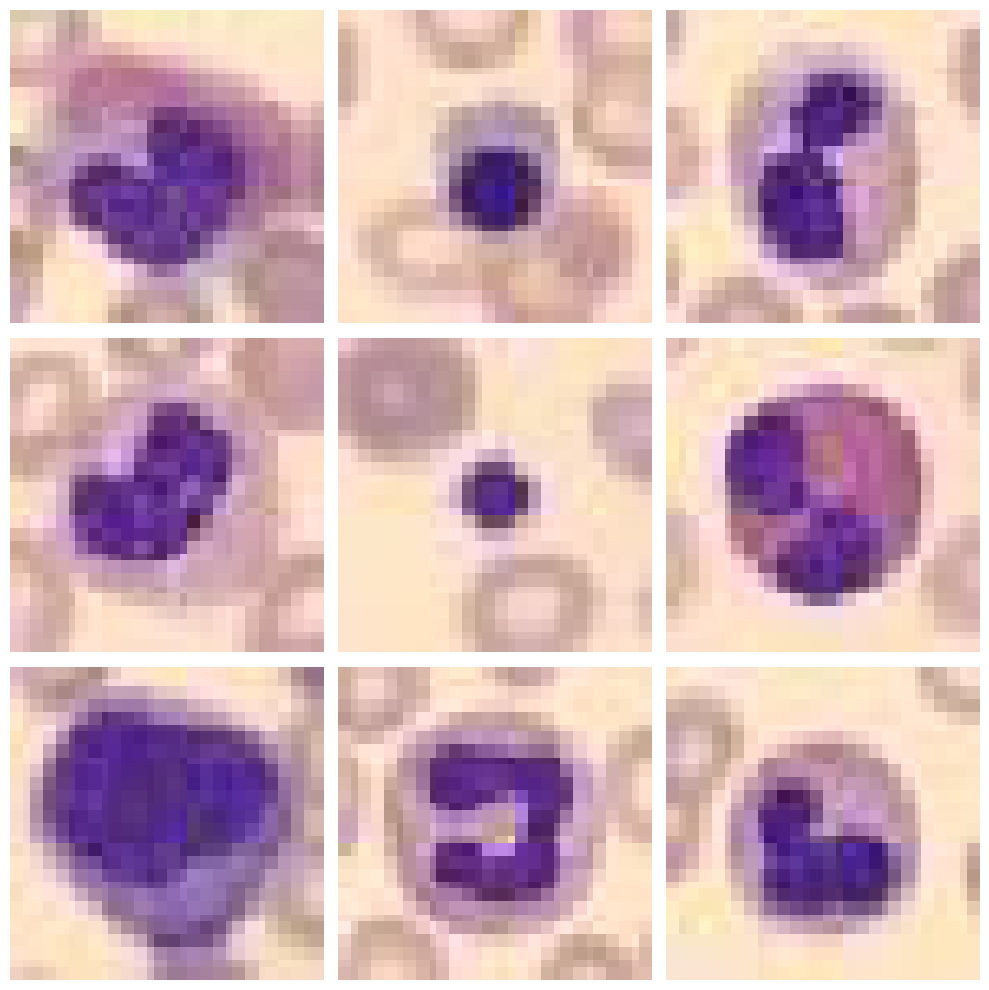

In [28]:
import matplotlib.pyplot as plt

# Function to display a grid of images
def display_sample_images(X, y, labels, num_images=9):
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        plt.subplot(3, 3, i + 1)
        idx = np.random.randint(0, len(X))
        plt.imshow(X[idx].squeeze(), cmap='gray' if X.shape[-1] == 1 else None)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Display 9 sample images
display_sample_images(X, y, labels)

In [29]:
from sklearn.model_selection import train_test_split
import numpy as np
# Use a seed for reproducibility
seed = 42

# Splitting the data without one-hot encoding the labels
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=seed)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=seed)

In [30]:
y_train = np.argmax(y_train, axis=1) if y_train.ndim > 1 else y_train
y_val = np.argmax(y_val, axis=1) if y_val.ndim > 1 else y_val
y_test = np.argmax(y_test, axis=1) if y_test.ndim > 1 else y_test


In [31]:
# Number of classes (ensure 'data['labels']' or 'y' has all possible labels)
num_classes = len(np.unique(y))
print(num_classes)

8


In [32]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from torchvision import transforms

# Define the transformations
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Helper function to create datasets, assuming X is already an appropriate format
def create_dataset(X, y, transform):
    X_transformed = [transform(x.astype('uint8')) for x in X]  # Assuming X is uint8 type if not already
    X_tensor = torch.stack(X_transformed)
    y_tensor = torch.tensor(y, dtype=torch.long)  # Ensure labels are long integers
    return TensorDataset(X_tensor, y_tensor)

# Create datasets
train_dataset = create_dataset(X_train, y_train, transform)
val_dataset = create_dataset(X_val, y_val, transform)
test_dataset = create_dataset(X_test, y_test, transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=10)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=10)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=10)

In [33]:
import torch.nn as nn
from torchvision.models import resnet18

# Initialize the model
model = resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Set device for model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [34]:
import torch.optim as optim

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train_model(num_epochs):
    for epoch in range(num_epochs):
        model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        print(f'Epoch {epoch+1}, Loss: {loss.item()}')

# Start training
train_model(5)  # Adjust the number of epochs as necessary

Epoch 1, Loss: 2.2152327801450156e-05
Epoch 2, Loss: 1.683453592704609e-05
Epoch 3, Loss: 1.299372706853319e-05
Epoch 4, Loss: 1.0510713764233515e-05
Epoch 5, Loss: 8.571402759116609e-06


In [35]:
# Set the model to evaluation mode
model.eval()
correct = 0
total = 0

# Evaluate the model on the test set
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Test Accuracy: {accuracy:.2f}%')

Test Accuracy: 100.00%
